In [1]:
pip install jupyter transformers torch

   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.4 kB ? eta -:--:--
   ----------- --------------------------- 41.0/139.4 kB 393.8 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.4 kB 544.7 kB/s eta 0:00:01
   ------------------------- ------------- 92.2/139.4 kB 525.1 kB/s eta 0:00:01
   ------------------------------ ------- 112.6/139.4 kB 544.7 kB/s eta 0:00:01
   -------------------------------------- 139.4/139.4 kB 549.7 kB/s eta 0:00:00
   ---------------------------------------- 0.0/123.4 kB ? eta -:--:--
   --------- ------------------------------ 30.7/123.4 kB 1.4 MB/s eta 0:00:01
   ------------ -------------------------- 41.0/123.4 kB 653.6 kB/s eta 0:00:01
   ------------------- ------------------- 61.4/123.4 kB 656.4 kB/s eta 0:00:01
   ----------------------------- --------- 92.2/123.4 kB 585.1 kB/s eta 0:00:01
   -------------------------------------- 123.4/123.4 kB 605.1 kB/s


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


LOAD PACKAGES, CLASSIFIER AND TOKENIZER MODELS

In [19]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd

# Load the model and tokenizer
model_directory = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Classifier Model\\macroecon_classifier'
tokenizer_directory = 'E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Classifier Model\\tokenizer_model'
model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_directory)

In [ ]:

# Test the model and tokenizer to confirm they are loaded correctly
text = "Having run an unsustainable macroeconomic model in tandem with the longstanding deficits in the budget balance and the external current account, the economy had fully exhausted its buffers by early 2022 as it was straddled by a myriad of vulnerabilities that emanated from both global and domestic sources."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

# Print the output to see the model's response
print(output)

Predict the macroeconomic factor

In [17]:
# Function to predict macroeconomic factors
def predict(text):
    # Encode the input text
    inputs = tokenizer(text, return_tensors='pt')
    
    # Get logits from the model
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits  # Now this should correctly reference logits
    
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1)
    
    # Assuming you have a list of labels corresponding to the order of model outputs
    labels = ['Inflation','International Trade','GDP Growth','Exchange Rates','Monetary Policy','Fiscal Policy','Unemployment']

    
    # Find the highest probability and its corresponding label
    prediction_idx = torch.argmax(probabilities)
    prediction_label = labels[prediction_idx]
    
    return prediction_label, probabilities[0, prediction_idx].item(),prediction_idx

# Example usage
text = 'The Government initiated measures in early 2022 to seek assistance from the International Monetary Fund (IMF) after months of indecisiveness.'

predicted_label, confidence , index= predict(text)
print(f"id: {index}, Predicted Label: {predicted_label}, Confidence: {confidence:.4f}")


id: 1, Predicted Label: International Trade, Confidence: 0.9998


Predict the whole csv file

In [30]:

model = AutoModelForSequenceClassification.from_pretrained(model_directory)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_directory)

def predict(text):
    # Ensure text is a string
    if pd.isna(text):
        return "No Text"  # Handle NaN values by returning a default label or similar indication
    text = str(text)  # Convert text to string in case it's not

    # Encode the input text, truncate if longer than 512 tokens
    inputs = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    
    # Get logits from the model
    with torch.no_grad():
        output = model(**inputs)
        logits = output.logits
    
    # Apply softmax to convert logits to probabilities
    probabilities = torch.softmax(logits, dim=-1)
    
    # Labels corresponding to the order of model outputs
    labels = ['Inflation', 'International Trade', 'GDP Growth', 'Exchange Rates', 'Monetary Policy', 'Fiscal Policy', 'Unemployment']
    
    # Find the highest probability and its corresponding label
    prediction_idx = torch.argmax(probabilities)
    prediction_label = labels[prediction_idx]
    
    return prediction_label

# Load the CSV file
df = pd.read_csv('E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\CreatingDataset\\macroeconomic_classifier_dataset_4_cleaned.csv')

# Apply predictions
df['predicted_label'] = df['sentence'].apply(predict)

# Save the updated DataFrame to a new CSV file
df.to_csv('E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\Classifier Model\\updated_file.csv', index=False)


EVALUATE MODEL PERFORMANCE

In [20]:
pip install pandas torch transformers scikit-learn seaborn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [33]:
# Load your test dataset
df_test = pd.read_csv('E:\\studies\\USJ FOT\\lecture\\Research\\CodeBase\\CreatingDataset\\macroeconomic_classifier_dataset_4_cleaned.csv')

Generate Predictions

In [36]:
def predict(text):
    if pd.isna(text) or text.strip() == "":
        return None  # Return None for missing or empty texts
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits
    return logits.argmax(-1).item()



 Prepare Labels for Metrics Calculation

In [37]:
# Convert sentences in the 'sentence' column to predicted labels
df_test['predicted_label'] = df_test['sentence'].apply(predict)

# Drop rows where prediction or true labels are None
df_test.dropna(subset=['predicted_label', 'label'], inplace=True)

# Convert true labels to integers using the mapping
label_mapping = {'Inflation': 0, 'International Trade': 1, 'GDP Growth': 2, 'Exchange Rates': 3, 'Monetary Policy': 4, 'Fiscal Policy': 5, 'Unemployment': 6}
df_test['true_label_id'] = df_test['label'].map(label_mapping)

# Convert to numpy arrays (ensure dtype is consistent)
true_labels = df_test['true_label_id'].values.astype(int)
predicted_labels = df_test['predicted_label'].values.astype(int)


Calculate and Print Metrics

Accuracy: 0.9735883424408015
Precision: 0.949600539531023
Recall: 0.9735883424408015
F1 Score: 0.9610176198545826


C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


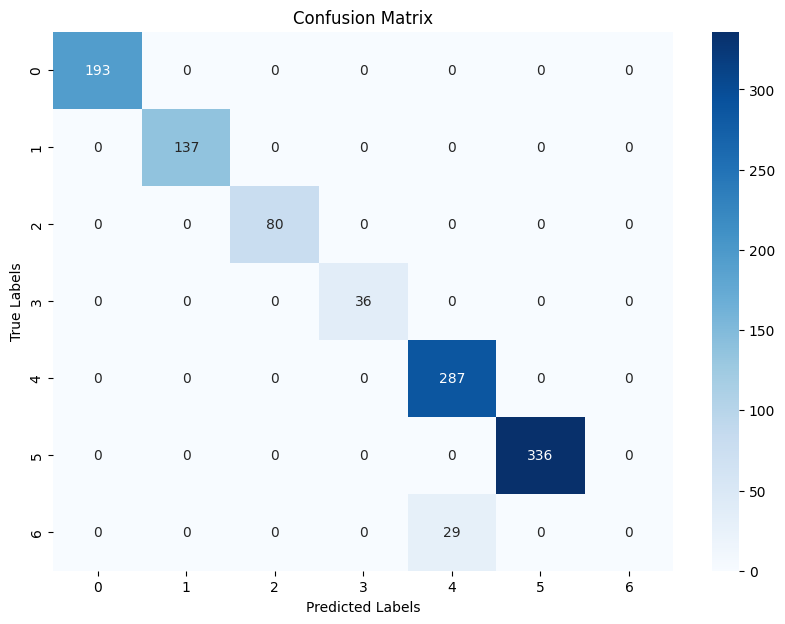

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
